# Alunos
Daniel Messias Santos - 202110168

Thiago Pereira Freire - 202110167

# GCC118 - Programação Matemática
## Profa. Andreza C. Beezão Moreira (DMM/UFLA)
## Prof. Mayron César O. Moreira (DCC/UFLA)

## Programação Inteira - Desafios de Modelagem

### Problema 1

Um empresa do ramo sucroalcooleiro está prestes a se instalar no noroeste do estado de São Paulo, e realiza um estudo para identificar quais cidades são as mais apropriadas para a fixação das novas plantas industriais. Existem um conjunto de $n$ localidades às quais exatamente $p$ delas serão escolhidas como pólos industriais da empresa.

Cada localidade $i$, $1 \le i \le n$, possui coordenadas geográficas $(x,y)$, e uma demanda total $d_i$ de produtos advindos da indústria sucroalcooleira a ser atendida. As $p$ localidades a serem determinadas também possuem suas demandas, além da sua própria capacidade. Deseja-se:   

* Determinar as $p$ localidades, entre as $n$ candidatas, tal que cada uma das $n$ seja atendida por exatamente uma das $p$ localidades, de forma que a soma das demandas atendidas por uma localidade determinada não exceda a sua capacidade.  

* Como critério de qualidade, pretende-se minimizar a soma das distâncias de cada pólo industrial para as localidades às quais ele atende. Para simplificar, considere a distância Euclidiana entre os pontos.  

#### Instância

A instância de teste pode ser obtida aqui: [link](https://drive.google.com/file/d/1HF6XQPZm6Sx4e6496c62l0DYh8pPDK6_/view?usp=sharing). As informações contidas são as seguintes:  

*id_instancia melhor_valor_conhecido*   
*total_localidades p_localidades capacidade_cada_p_localidade*  
*id_localidade coord_x coord_y demanda*



In [ ]:
!pip install pulp

In [ ]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary
import math

# Dados do problema
n = 0
p = 0
capacidade = 0
localidades = []

# Leitura do arquivo
with open("p1.dat", "r") as arquivo:
    arquivo.readline()
    dados = arquivo.readline().split()

    # Número total de localidades, polos e capacidade
    n = int(dados[0])
    p = int(dados[1])
    capacidade = int(dados[2])

    for linha in arquivo.readlines():
        partes = linha.split()
        localidades.append([int(partes[0]), int(partes[1]), int(partes[2]), int(partes[3])])  # [coord_x, coord_y, id, demanda]

# Cálculo das distâncias Euclidianas entre localidades
distancias = [[math.sqrt((localidades[i][0] - localidades[j][0]) ** 2 +
                         (localidades[i][1] - localidades[j][1]) ** 2)
               for j in range(n)] for i in range(n)]

# Criação do modelo
modelo = LpProblem("LocalizacaoIndustrial", LpMinimize)

# Variáveis de decisão
x = [[LpVariable(f"x_{i}_{j}", 0, 1, LpBinary) for j in range(n)] for i in range(n)]
y = [LpVariable(f"y_{j}", 0, 1, LpBinary) for j in range(n)]

# Função objetivo: minimizar a soma das distâncias ponderadas pelas demandas
modelo += lpSum(distancias[i][j] * localidades[i][3] * x[i][j] for i in range(n) for j in range(n))

# Restrição 1: Cada localidade deve ser atendida por exatamente um polo
for i in range(n):
    modelo += lpSum(x[i][j] for j in range(n)) == 1, f"Atendimento_{i}"

# Restrição 2: Capacidade dos polos não pode ser excedida
for j in range(n):
    modelo += lpSum(localidades[i][3] * x[i][j] for i in range(n)) <= capacidade * y[j], f"Capacidade_{j}"

# Restrição 3: Apenas polos escolhidos podem atender
for i in range(n):
    for j in range(n):
        modelo += x[i][j] <= y[j], f"VinculoPolo_{i}_{j}"

# Restrição 4: Exatamente p polos devem ser escolhidos
modelo += lpSum(y[j] for j in range(n)) == p, "QuantidadePolos"

# Resolução do modelo
modelo.solve()

# Exibição dos resultados
if modelo.status == 1:  # Solução ótima encontrada
    print(f"\nSolução ótima encontrada com custo total: {modelo.objective.value():.2f}")
    for j in range(n):
        if y[j].value() > 0.5:
            print(f"Polo escolhido na localidade {j}:")
            for i in range(n):
                if x[i][j].value() > 0.5:
                    print(f"  - Atende localidade {i} (demanda: {localidades[i][3]})")
else:
    print("Não foi possível encontrar uma solução ótima.")


### Problema 2

Considere uma linha de produção composta por um conjunto $N$ de tarefas. A linha é ritmada, e composta por um conjunto $S$ de estações de trabalho linearmente dispostas em um sistema do tipo *straight line*. As estações são compostas por equipamentos idênticos, de forma que o tempo de execução da tarefa em qualquer estação é dado por $t_i$, $i \in N$.

Para manter um nível mínimo de produtividade na linha, considere que a soma dos tempos de todas as tarefas designadas a uma estação de trabalho não exceda o valor de $C$ unidades. Como as tarefas seguem regras de negócio para a fabricação do produto da linha, define-se precedências entre elas, de forma que se a tarefa $i$ precede a tarefa $j$, e $s(x)$ é o identificador da estação considerada para a alocação da tarefa $x$, então $s(i) \le s(j)$.

Diante disso, crie um modelo inteiro que minimiza o número de estações instaladas na linha de produção. Para testar, considere a instância no seguinte endereço: [link](https://drive.google.com/file/d/1dJI4qOzH5hT-tpSy4Oel3ONHYUehBgOt/view?usp=sharing).

In [ ]:
!pip install pulp

In [ ]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary

# Função para ler os dados do arquivo
def read_data(filename):
    with open(filename, "r") as f:
        # Leitura do número de tarefas
        f.readline()  # Ignorar a linha "<number of tasks>"
        num_tasks = int(f.readline().strip())
        f.readline()

        # Leitura do tempo de ciclo
        f.readline()
        cycle_time = int(f.readline().strip())
        f.readline()

        # Leitura da ordem de precedência (não utilizada diretamente neste modelo)
        f.readline()
        order_strength = (f.readline().strip())
        f.readline()
        f.readline()

        # Leitura dos tempos das tarefas
        task_times = []
        # Ignorar o marcador <task times>
        f.readline()  # Ignora a linha "<task times>"
        for _ in range(num_tasks):
            task_id, task_time = map(int, f.readline().strip().split())
            task_times.append((task_id, task_time))

        # Leitura das relações de precedência
        precedence_relations = []
        # Ignorar o marcador <precedence relations>
        f.readline()
        f.readline()  # Ignora a linha "<precedence relations>"
        while True:
            line = f.readline().strip()
            if line == "<end>" or line == '':
                break
            task_i, task_j = map(int, line.split(","))
            precedence_relations.append((task_i, task_j))

    return num_tasks, task_times, cycle_time, precedence_relations

# Ler os dados do arquivo
filename = "p12.dat"
num_tasks, task_times, cycle_time, precedence_relations = read_data(filename)

# Criar o modelo de programação inteira
max_stations = num_tasks  # Pior caso: cada tarefa em uma estação
model = LpProblem("LineBalancing", LpMinimize)

# Variáveis de decisão
x = LpVariable.dicts("x", ((i, s) for i in range(1, num_tasks + 1) for s in range(1, max_stations + 1)), 0, 1, LpBinary)
y = LpVariable.dicts("y", (s for s in range(1, max_stations + 1)), 0, 1, LpBinary)

# Função objetivo: minimizar o número de estações
model += lpSum(y[s] for s in range(1, max_stations + 1))

# Restrição 1: Cada tarefa deve ser atribuída exatamente a uma estação
for i, _ in task_times:
    model += lpSum(x[i, s] for s in range(1, max_stations + 1)) == 1

# Restrição 2: O tempo total das tarefas em uma estação não pode exceder o tempo de ciclo
for s in range(1, max_stations + 1):
    model += lpSum(task_times[i - 1][1] * x[i, s] for i in range(1, num_tasks + 1)) <= cycle_time * y[s]

# Restrição 3: Precedência das tarefas
for i, j in precedence_relations:
    model += lpSum(s * x[i, s] for s in range(1, max_stations + 1)) <= lpSum(s * x[j, s] for s in range(1, max_stations + 1))

# Resolução do modelo
model.solve()

# Exibição dos resultados
if model.status == 1:
    print(f"Solução ótima encontrada com {sum(y[s].value() for s in range(1, max_stations + 1)):.0f} estações:")
    for s in range(1, max_stations + 1):
        if y[s].value() > 0.5:
            print(f"Estação {s}:")
            for i, _ in task_times:
                if x[i, s].value() > 0.5:
                    print(f"  - Tarefa {i} (tempo: {task_times[i - 1][1]})")
else:
    print("Não foi possível encontrar uma solução ótima.")


### Problema 3

Um jogo de tabuleiro está *viralizando* na *web*. Para entendê-lo, considere a figura abaixo.

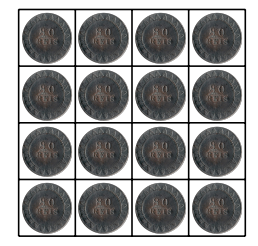

Trata-se de um tabuleiro $4 \times 4$, em que cada posição possui uma moeda. Deseja-se remover 6 das 16 moedas, de forma que cada linha e cada coluna possua um número par de moedas. Como critério de qualidade, **o objetivo é maximizar o número de moedas na diagonal principal.**

Muitos tentam resolver tal jogo via tentativa e erro. Porém, você, como um dedicado aluno de Programação Matemática, resolverá através de um modelo de Programação Inteira.

In [ ]:
!pip install pulp

In [ ]:
import pulp

# Modelo
model = pulp.LpProblem("Tabuleiro_4x4", pulp.LpMaximize)

# Variáveis de decisão: x[i][j]
x = [[pulp.LpVariable(f"x_{i}_{j}", cat="Binary") for j in range(4)] for i in range(4)]

# Variáveis auxiliares para garantir paridade (somas inteiras)
y_linha = [pulp.LpVariable(f"y_linha_{i}", lowBound=0, cat="Integer") for i in range(4)]
y_coluna = [pulp.LpVariable(f"y_coluna_{j}", lowBound=0, cat="Integer") for j in range(4)]

# Objetivo: Maximizar moedas na diagonal principal
model += pulp.lpSum(x[i][i] for i in range(4)), "Maximizar_diagonal"

# Restrição: Cada linha deve ter número par de moedas
for i in range(4):
    model += pulp.lpSum(x[i][j] for j in range(4)) == 2 * y_linha[i], f"Paridade_linha_{i}"

# Restrição: Cada coluna deve ter número par de moedas
for j in range(4):
    model += pulp.lpSum(x[i][j] for i in range(4)) == 2 * y_coluna[j], f"Paridade_coluna_{j}"

# Restrição: Seis moedas devem ser removidas
model += pulp.lpSum(1 - x[i][j] for i in range(4) for j in range(4)) == 6, "Remover_seis_moedas"

# Resolver o modelo
status = model.solve()

# Resultado
tabuleiro = [[int(pulp.value(x[i][j])) for j in range(4)] for i in range(4)]
for linha in tabuleiro:
    print(linha)

